# Regularization

Regularization is a broad group of techniques intended for reducing overfitting.
Most regularizations methods aim at introducing a preference for simpler models,
instead of forcing simpler models through reduced model capacity. 
A soft preference is more diserable because the algorithm can still choose a very complex model,
but regularization requires such complex model to have a significant performance improvement over simpler models.

$$ 
\text{Cost}\big(\textbf{Y}, \hat{\textbf{Y}}, \textbf{W}\big) 
= \text{Supervised Cost}(\textbf{Y}, \hat{\textbf{Y}}) 
+ \alpha * \text{Regularization Cost}(\textbf{W}) 
$$

Hyperparameter $ \alpha \in [0, \infty] $ controls the balance between supervised and regularization costs. It's advised to first train a model that has the lowest possible training cost, and only then enable regularization to improve the validation metrics.

### Vector Norms

Most frequently used regularization methods are based on the vector norm of the weights. Vector norms are functions that measure the magnitude of a vector with a single scalar, and satisfy the following properties:

$ f(\textbf{v}) \in ℝ^n \rightarrow ℝ $

$ f(\textbf{a} + \textbf{b}) \le f(\textbf{a}) + f(\textbf{b}) $

$ f(c * \textbf{a}) = |c| f(\textbf{a}) $

$ f(\textbf{a}) = 0 \rightarrow \textbf{a} = \textbf{0} $

In short, the vector norm grows proportionally to the absolute growth of the vector's entries.
If a vector has large entries (in absolute terms), then its norm will be large too. 
If a vector has small entries (in absolute terms), then its norm will be small too. 

When applied to the weights vector of a neural network, the vector norm is a proxy for the network's complexity.
Consider an extreme case: when a neuron's weights (including the biases) are all zero, the neuron is effectively
removed from the network, and the network's complexity goes down. Minimizing both the supervised cost and the weights vector's norm corresponds to asking to solve the supervised problem with the least number of neurons possible. This explanation is mathematically oversimplified, but it conveys the general idea.

In practice, we use two types of vector norms defined as:

$$
\begin{align}
    \text{L}_1(\textbf{W}) & = \sum_i^n{|w_i|} \\
    \text{L}_2(\textbf{W}) & = \frac{1}{2} \sum_i^n{w_i^2} 
\end{align}
$$

$$
\begin{align}
    \frac{d \text{L}_1} {d w_i} & = 
    \begin{cases}
        1 & \text{if } w_i \ge 0 \\
        -1 & \text{otherwise}
    \end{cases}
    \\
    \frac{d \text{L}_2} {d w_i} & = w_i 
\end{align}
$$

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

theta = np.linspace(-5, 5, 10000)
l1 = np.abs(theta)
l2 = (theta ** 2) / 2

l1_gradient = np.empty(theta.shape)
l1_gradient[theta <= 0] = -1
l1_gradient[theta > 0] = 1

l2_gradient = theta

l1_gradient, l2_gradient

(array([-1., -1., -1., ...,  1.,  1.,  1.]),
 array([-5.       , -4.9989999, -4.9979998, ...,  4.9979998,  4.9989999,
         5.       ]))

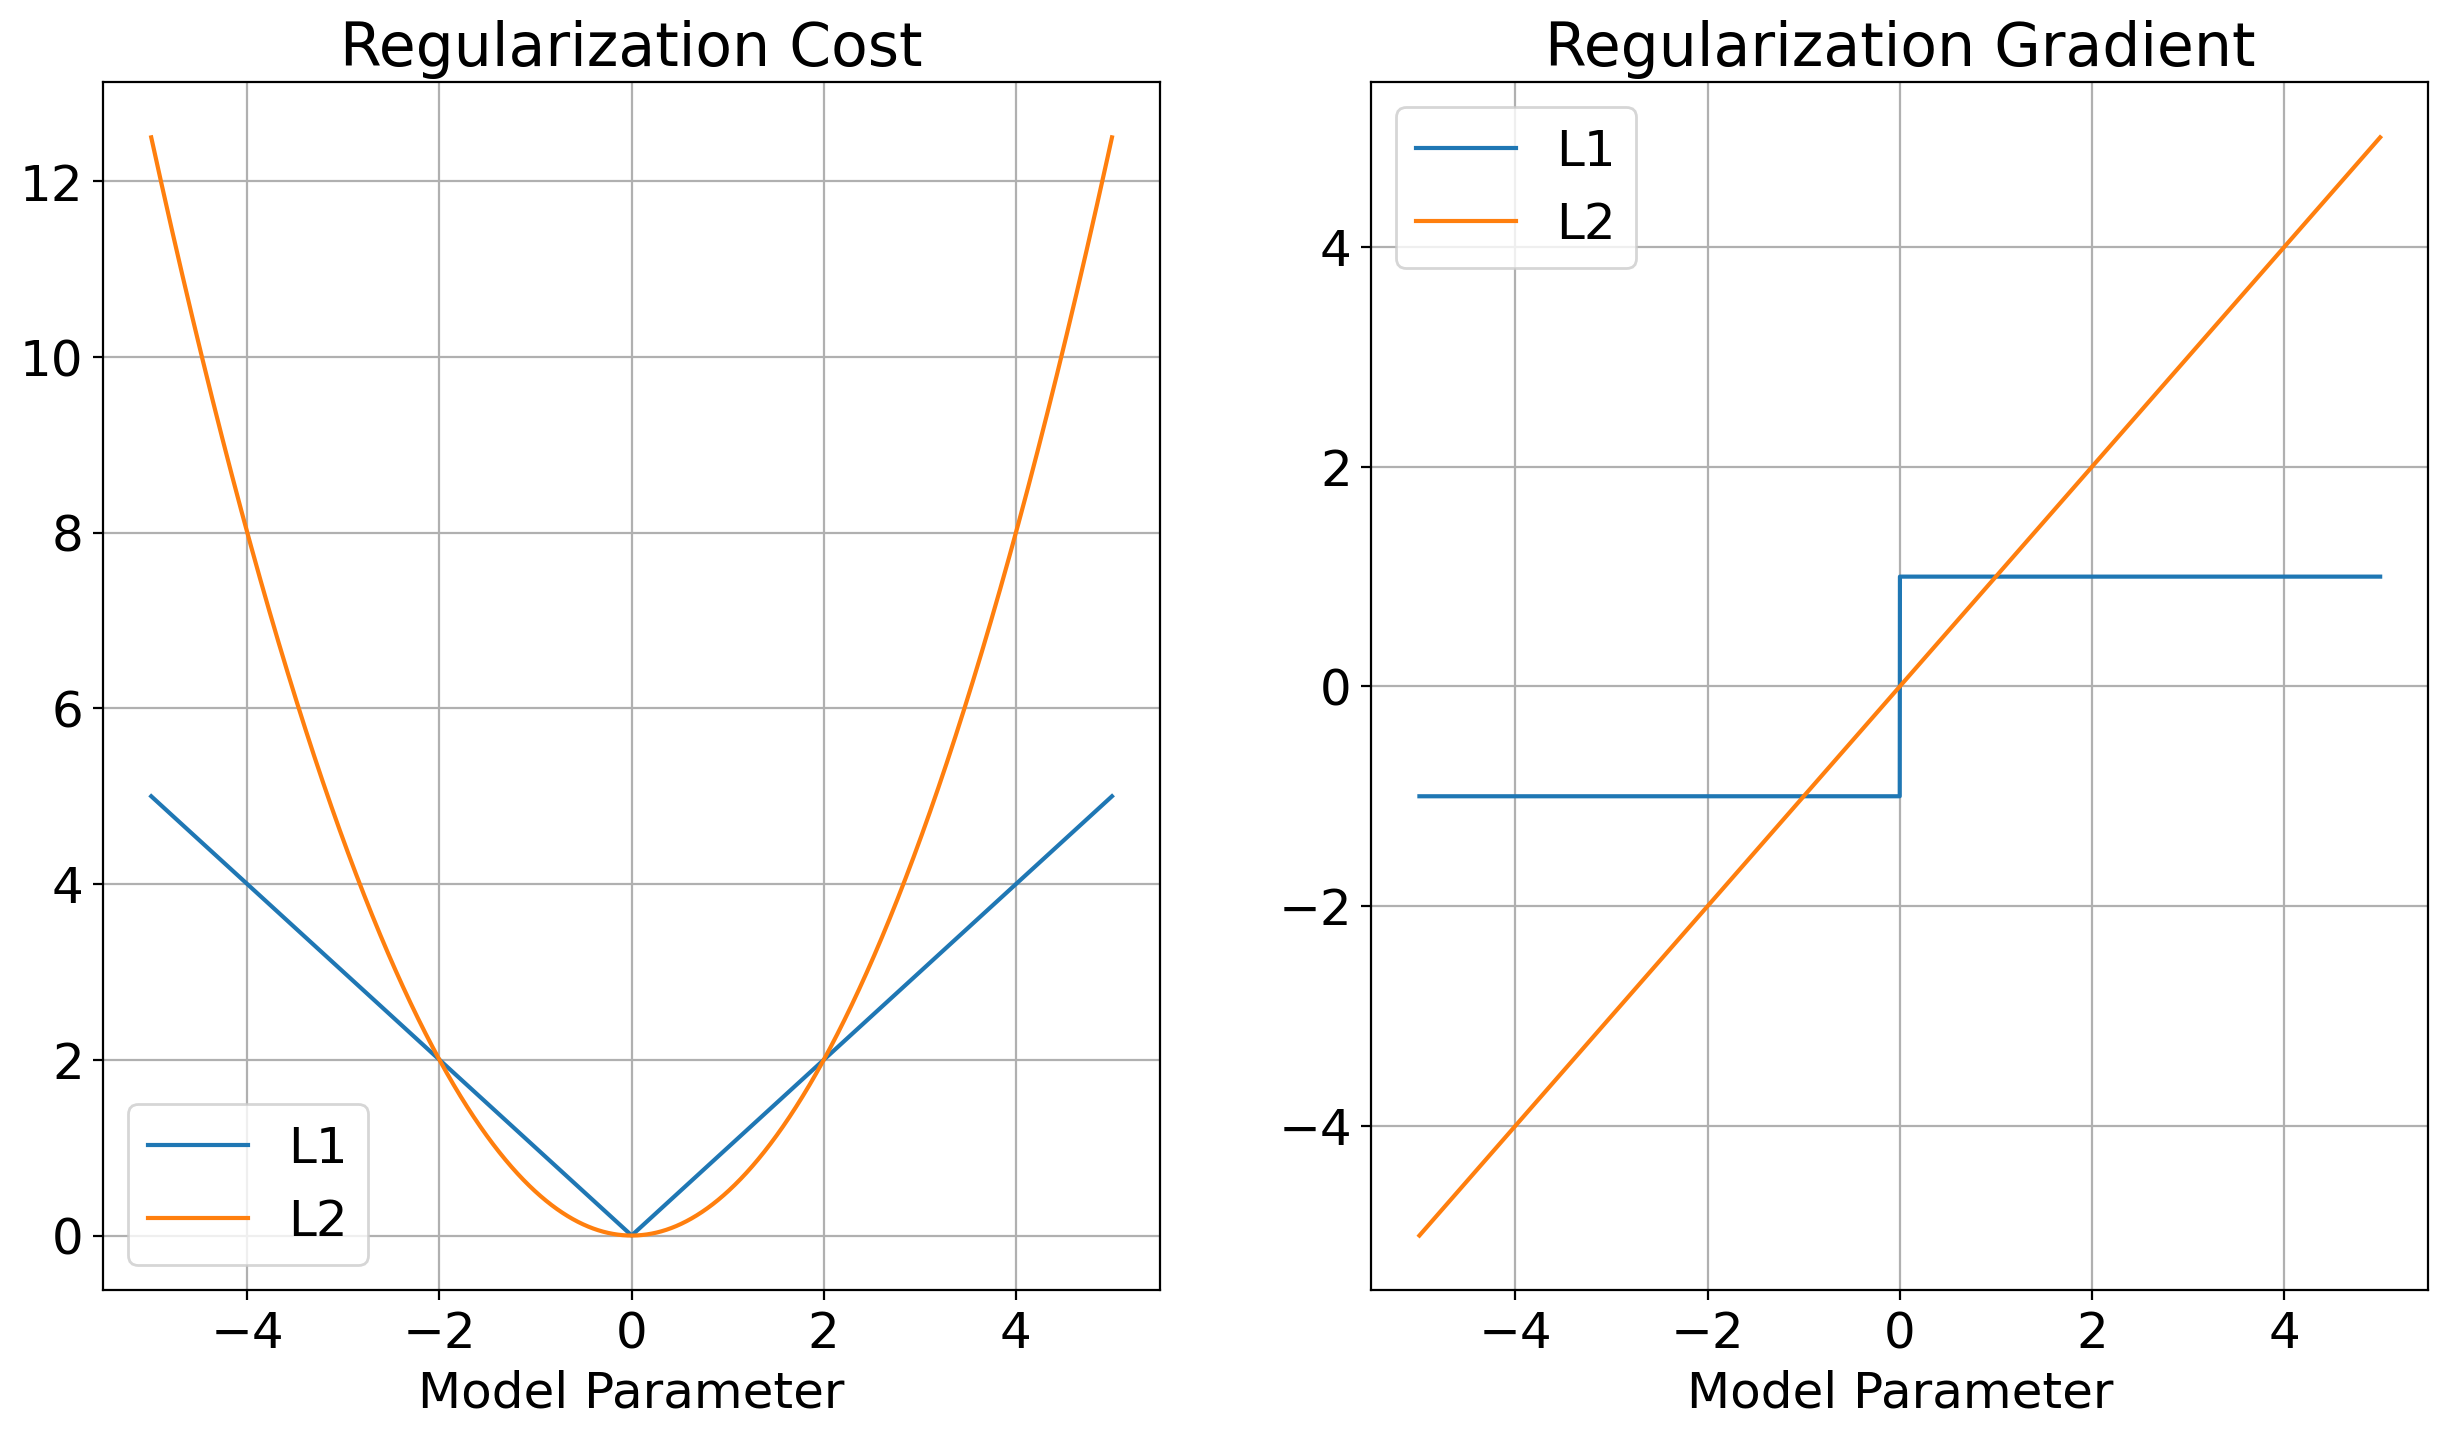

In [2]:
mpl.rcParams.update({'font.size': 18})
plt.figure(figsize=[15, 8], dpi=100)
plt.subplot(1, 2, 1)
plt.title('Regularization Cost')
sns.lineplot(theta, l1, label='L1')
sns.lineplot(theta, l2, label='L2')
plt.xlabel('Model Parameter')
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.subplot(1, 2, 2)
plt.title('Regularization Gradient')
sns.lineplot(theta, l1_gradient, label='L1')
sns.lineplot(theta, l2_gradient, label='L2')
plt.xlabel('Model Parameter')
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.show()

In [4]:
from tensorflow.keras import regularizers

# Docs: https://keras.io/regularizers/
?regularizers.l1

Signature: regularizers.l1(l=0.01)
Docstring:
Create a regularizer that applies an L1 regularization penalty.

The L1 regularization penalty is computed as:
$$\ell_1\,\,penalty =\ell_1\sum_{i=0}^n|x_i|$$

Arguments:
    l: Float; L1 regularization factor.

Returns:
  An L1 Regularizer with the given regularization factor.
File:      /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/regularizers.py
Type:      function


In [5]:
?regularizers.l2

Signature: regularizers.l2(l=0.01)
Docstring:
Create a regularizer that applies an L2 regularization penalty.

The L2 regularization penalty is computed as:
$$\ell_2\,\,penalty =\ell_2\sum_{i=0}^nx_i^2$$

Arguments:
    l: Float; L2 regularization factor.

Returns:
  An L2 Regularizer with the given regularization factor.
File:      /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/regularizers.py
Type:      function
